<a href="https://colab.research.google.com/github/Shobhit-2510/Advanced-DL-Project-Brain-Tumor-Image-Classification/blob/main/Advanced_DL_Project_Brain_Tumor_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Dependencies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil
import cv2
import matplotlib.image as mpimg
%matplotlib inline
plt.style.use('ggplot')

# Importing Dataset

In [ ]:
# mount drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!cp /content/drive/MyDrive/Datasets_for_DL/Brain_Tumor.zip /content/Brain_Tumor.zip

In [ ]:
# extract file
!unzip /content/Brain_Tumor.zip

Archive:  /content/Brain_Tumor.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_dataset/no/28 no.jpg  
  inf

In [ ]:
!rm /content/Brain_Tumor.zip

In [ ]:
!rm -rf /content/yes
!rm -rf /content/no

## Organise Files

In [ ]:
folder = 'brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
  source = folder + filename
  destination = folder + "Y_" + str(count)
  os.rename(source, destination)
  count += 1

In [ ]:
folder = 'brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
  source = folder + filename
  destination = folder + "N_" + str(count)
  os.rename(source, destination)
  count += 1

# Exploratory Data Analysis (EDA)

In [ ]:
yes_files_list = os.listdir('brain_tumor_dataset/yes/')
no_files_list = os.listdir('brain_tumor_dataset/no/')

num_yes_files = len(yes_files_list)
num_no_files = len(no_files_list)

print('Number of yes files: ', (num_yes_files))
print('Number of no files: ', (num_no_files))

Number of yes files:  155
Number of no files:  98


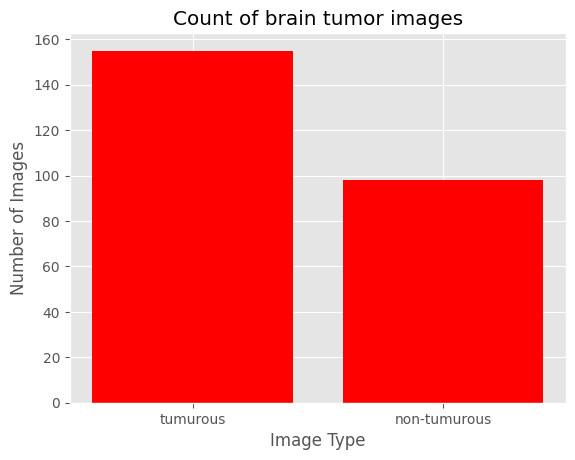

In [ ]:
data = {"tumurous" : num_yes_files, "non-tumurous": num_no_files}

keys = data.keys()
values = data.values()

plt.bar(keys,values,color='red')
plt.title("Count of brain tumor images")
plt.xlabel("Image Type")
plt.ylabel("Number of Images")
plt.show()

Initially:

*   Tumorous – 155 (61%)
*   Non-Tumorous – 98 (39%)

After augmentation:

*   Tumorous – 155 + 155×6 = 1085
*   Non-Tumorous – 98 + 98×9 = 980

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
def timing(sec_elapsed):
  h = int(sec_elapsed / (60*60))
  m = int(sec_elapsed % (60*60) / 60)
  s = sec_elapsed % 60
  return f"{h}:{m}:{s}"

In [ ]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
  # generating a object of ImageDataGenerator
  data_gen = ImageDataGenerator(rotation_range=10,
                                width_shift_range = 0.1,
                                shear_range = 0.1,
                                brightness_range = (0.3,1.0),
                                horizontal_flip = True,
                                vertical_flip = True,
                                fill_mode = 'nearest')
  for filename in os.listdir(file_dir):
    image = cv2.imread(file_dir + "/" + filename) # imread() returns image as 3d numpy array
    image = image.reshape((1,) + image.shape) # giving input as concetanation of two tuples
    save_prefix = 'aug_' + filename[:-4]
    i = 0
    # .flow() method takes image input in batch of images (numpy array)
    # but we giving a single image in a 4d array and saving it in directory
    for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = 'jpg'):
      i+=1
      if i>n_generated_samples:
        break

In [ ]:
!mkdir /content/augmented_data/
!rm -rf /content/augmented_data/yes/
!mkdir /content/augmented_data/yes/
!rm -rf /content/augmented_data/no/
!mkdir /content/augmented_data/no/

In [ ]:
import time
start_time = time.time()
yes_path = "brain_tumor_dataset/yes/"
no_path = "brain_tumor_dataset/no/"

augmented_data_path = "augmented_data/"

augmented_data(file_dir = yes_path, n_generated_samples=6, save_to_dir = augmented_data_path + 'yes')
augmented_data(file_dir = no_path, n_generated_samples=9, save_to_dir = augmented_data_path + 'no')
end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {timing(execution_time)}")

Elapsed time: 0:2:2.255131483078003


In [ ]:
def data_summary(main_path):
  yes_path = main_path + "yes/"
  no_path = main_path + "no/"

  n_pos = len(os.listdir(yes_path))
  n_neg = len(os.listdir(no_path))

  n = n_pos + n_neg
  pos_per = (n_pos*100.0)/n
  neg_per = (n_neg*100.0)/n

  print(f"Total number of images: {n}")
  print(f"Number of positive images: {n_pos}")
  print(f"Number of negative images: {n_neg}")
  print(f"Percentage of positive images: {pos_per} %")
  print(f"Percentage of negative images: {neg_per} %")

In [ ]:
data_summary(augmented_data_path)

Total number of images: 1990
Number of positive images: 1058
Number of negative images: 932
Percentage of positive images: 53.165829145728644 %
Percentage of negative images: 46.834170854271356 %


In [ ]:
yes_files_list = os.listdir('augmented_data/yes/')
no_files_list = os.listdir('augmented_data/no/')

num_yes_files = len(yes_files_list)
num_no_files = len(no_files_list)

print('Number of yes files: ', (num_yes_files))
print('Number of no files: ', (num_no_files))

Number of yes files:  1058
Number of no files:  932


Got less augmented images than expected because some images discarded due to some error in function.

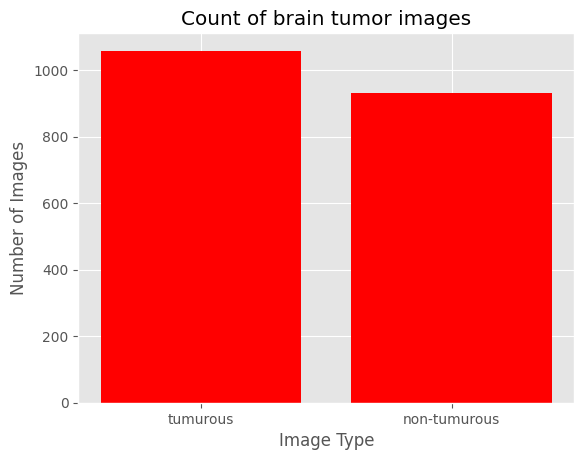

In [ ]:
data = {"tumurous" : num_yes_files, "non-tumurous": num_no_files}

keys = data.keys()
values = data.values()

plt.bar(keys,values,color='red')
plt.title("Count of brain tumor images")
plt.xlabel("Image Type")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
!rm -rf /content/brain_tumor_dataset/

# Data Preprocessing

## Theory

Threshold

```
ret,thresh1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
ret,thresh2 = cv.threshold(img,127,255,cv.THRESH_BINARY_INV)
ret,thresh3 = cv.threshold(img,127,255,cv.THRESH_TRUNC)
ret,thresh4 = cv.threshold(img,127,255,cv.THRESH_TOZERO)
ret,thresh5 = cv.threshold(img,127,255,cv.THRESH_TOZERO_INV)
```
127 → This is the threshold value.

255 → This is the maximum value to use when assigning pixel values for the binary result.
```
if pixel > 127:
    pixel = 255
else:
    pixel = 0
```

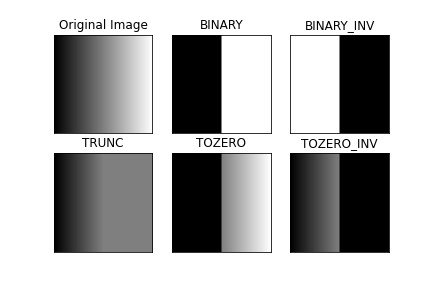

What does this Opening achieve?

Opening (Erosion → Dilation) smooths object contours.

Removes small noise and isolated white points.

Separates objects that are close together.

Maintains the general size and shape of larger objects, without noise.

Shape of contour is (N, 1, 2)

- N - Number of poins
- 1 - extra dimension for consistency with c++
- 2 - (x,y) coordinates

## Code

In [ ]:
import imutils
def crop_brain_tumor(image, plot=False):
  # taking image input as numpy array
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5,5), 0)

  thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thres = cv2.erode(thres, None, iterations = 2)
  thres = cv2.dilate(thres, None, iterations = 2)

  cnts = cv2.findContours(thres.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  '''
  Below one step is necessary step because code may break due to inconsistency in
  OpenCV versions (grab_contours() return list of array of points of contour)
  '''
  cnts = imutils.grab_contours(cnts)
  # returns contour(array of points(x,y)) with maximum area calculated by function (cv2.contourArea())
  c = max(cnts, key = cv2.contourArea)

  # argmin() gives index of smallest element in numpy 1d array or 2d by flattening it
  extLeft = tuple(c[c[:,:,0].argmin()][0]) # extreme left point of contour c
  extRight = tuple(c[c[:,:,0].argmax()][0]) # extreme right point of contour c
  extTop = tuple(c[c[:,:,1].argmin()][0]) # extreme top point of contour c
  extBot = tuple(c[c[:,:,1].argmax()][0]) # extreme bottom point of contour c

  new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] # slicing 2d array of image

  if plot:
      plt.figure()
      plt.subplot(1, 2, 1)
      plt.imshow(image)

      plt.tick_params(axis='both', which='both',
                      top=False, bottom=False, left=False, right=False,
                      labelbottom=False, labeltop=False, labelleft=False, labelright=False)

      plt.title('Original Image')

      plt.subplot(1, 2, 2)
      plt.imshow(new_image)

      plt.tick_params(axis='both', which='both',
                      top=False, bottom=False, left=False, right=False,
                      labelbottom=False, labeltop=False, labelleft=False, labelright=False)

      plt.title('Cropped Image')
      plt.show()
  return new_image

Tumoruos Image

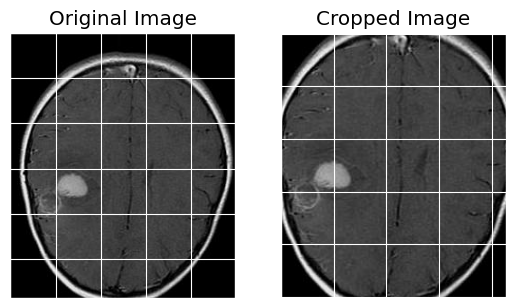

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
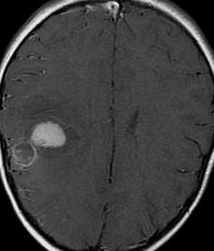

In [ ]:
yes_dir = os.listdir('/content/augmented_data/yes')
# Construct the full path to the image file
img_path = os.path.join('/content/augmented_data/yes', yes_dir[0])
img = cv2.imread(img_path)
crop_brain_tumor(img, plot=True)

Non - Tumoruos Image

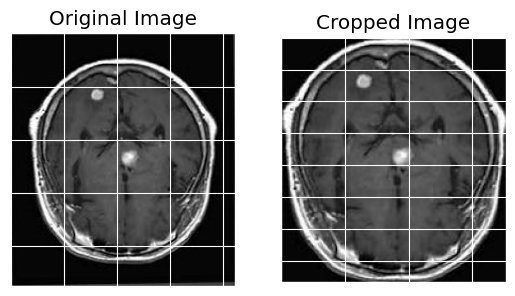

array([[[6, 6, 6],
        [6, 6, 6],
        [6, 6, 6],
        ...,
        [6, 6, 6],
        [6, 6, 6],
        [6, 6, 6]],

       [[6, 6, 6],
        [6, 6, 6],
        [6, 6, 6],
        ...,
        [6, 6, 6],
        [6, 6, 6],
        [6, 6, 6]],

       [[6, 6, 6],
        [6, 6, 6],
        [6, 6, 6],
        ...,
        [6, 6, 6],
        [6, 6, 6],
        [6, 6, 6]],

       ...,

       [[6, 6, 6],
        [6, 6, 6],
        [6, 6, 6],
        ...,
        [6, 6, 6],
        [6, 6, 6],
        [6, 6, 6]],

       [[6, 6, 6],
        [6, 6, 6],
        [6, 6, 6],
        ...,
        [6, 6, 6],
        [6, 6, 6],
        [6, 6, 6]],

       [[6, 6, 6],
        [6, 6, 6],
        [6, 6, 6],
        ...,
        [6, 6, 6],
        [6, 6, 6],
        [6, 6, 6]]], dtype=uint8)
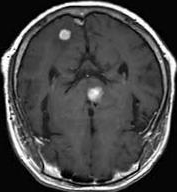

In [ ]:
no_dir = os.listdir('/content/augmented_data/no')
# Construct the full path to the image file
img_path = os.path.join('/content/augmented_data/no', no_dir[0])
img = cv2.imread(img_path)
crop_brain_tumor(img, plot=True)

In [ ]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
    img = cv2.imread(folder1 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder1 + filename, img)
for filename in os.listdir(folder2):
    img = cv2.imread(folder2 + filename)
    img = crop_brain_tumor(img, False)
    cv2.imwrite(folder2 + filename, img)

In [ ]:
# image loading
from sklearn.utils import shuffle
def load_data(dir_list, image_size):
    X=[]
    y=[]

    image_width, image_height=image_size

    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            # image = crop_brain_tumor(image, plot=False) # not cropping because already cropped
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            image = image/255.00
            X.append(image)
            if directory[-3:] == "yes":
                y.append(1)
            else:
                y.append(0)
    X=np.array(X)
    y=np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y

In [ ]:
from sklearn.utils import shuffle
augmented_path = "augmented_data/"

augmented_yes = augmented_path + "yes"
augmented_no = augmented_path + "no"

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))


Number of example is : 1990
X SHAPE is : (1990, 240, 240, 3)
y SHAPE is : (1990,)


In [ ]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])

            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

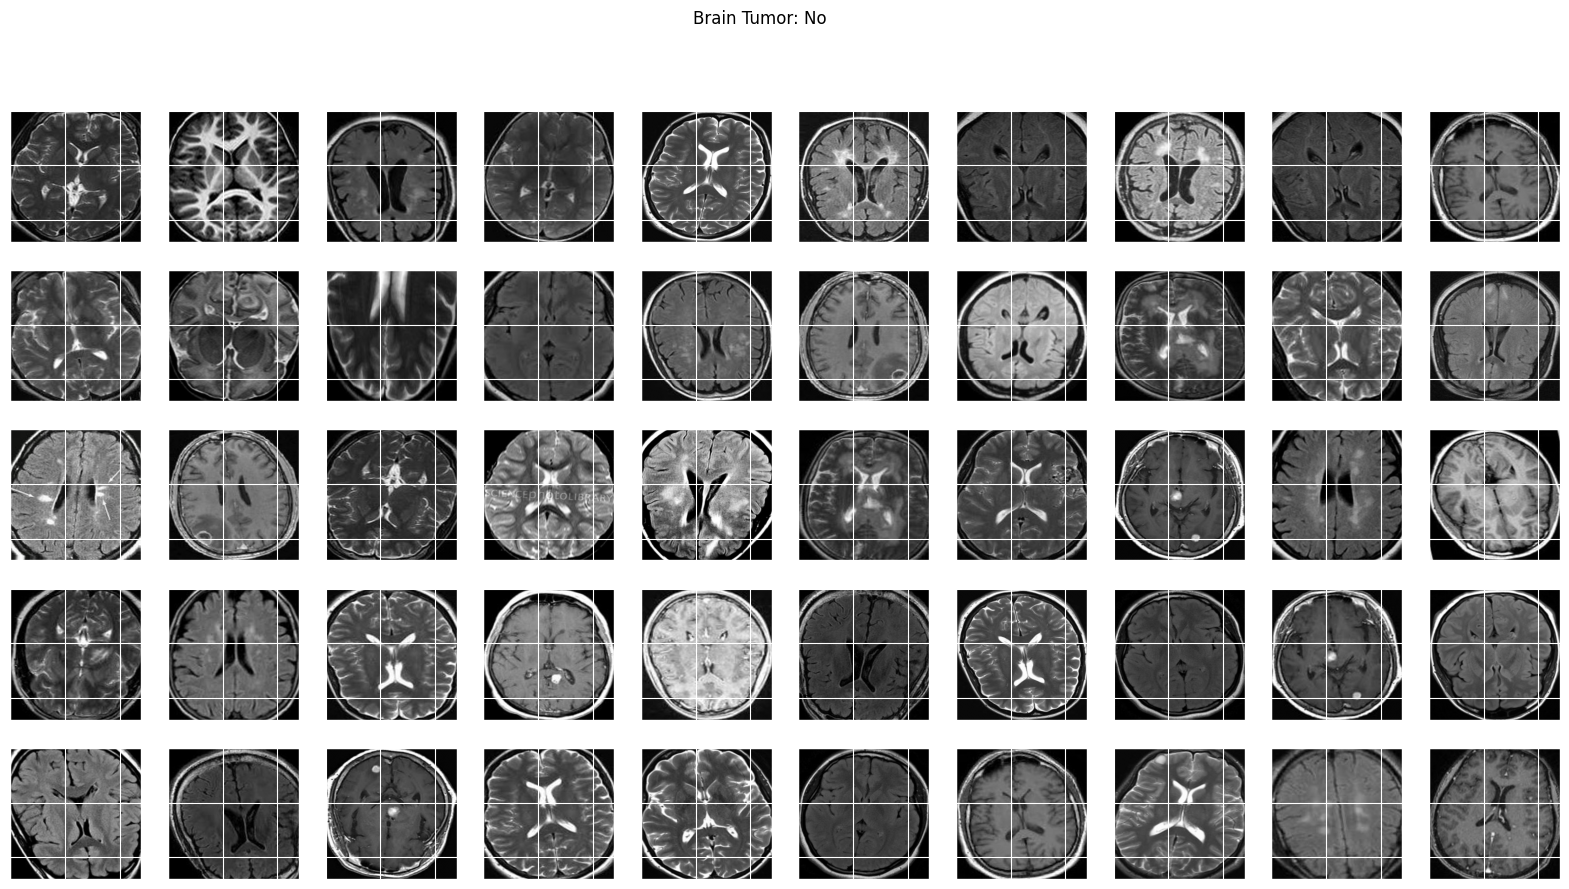

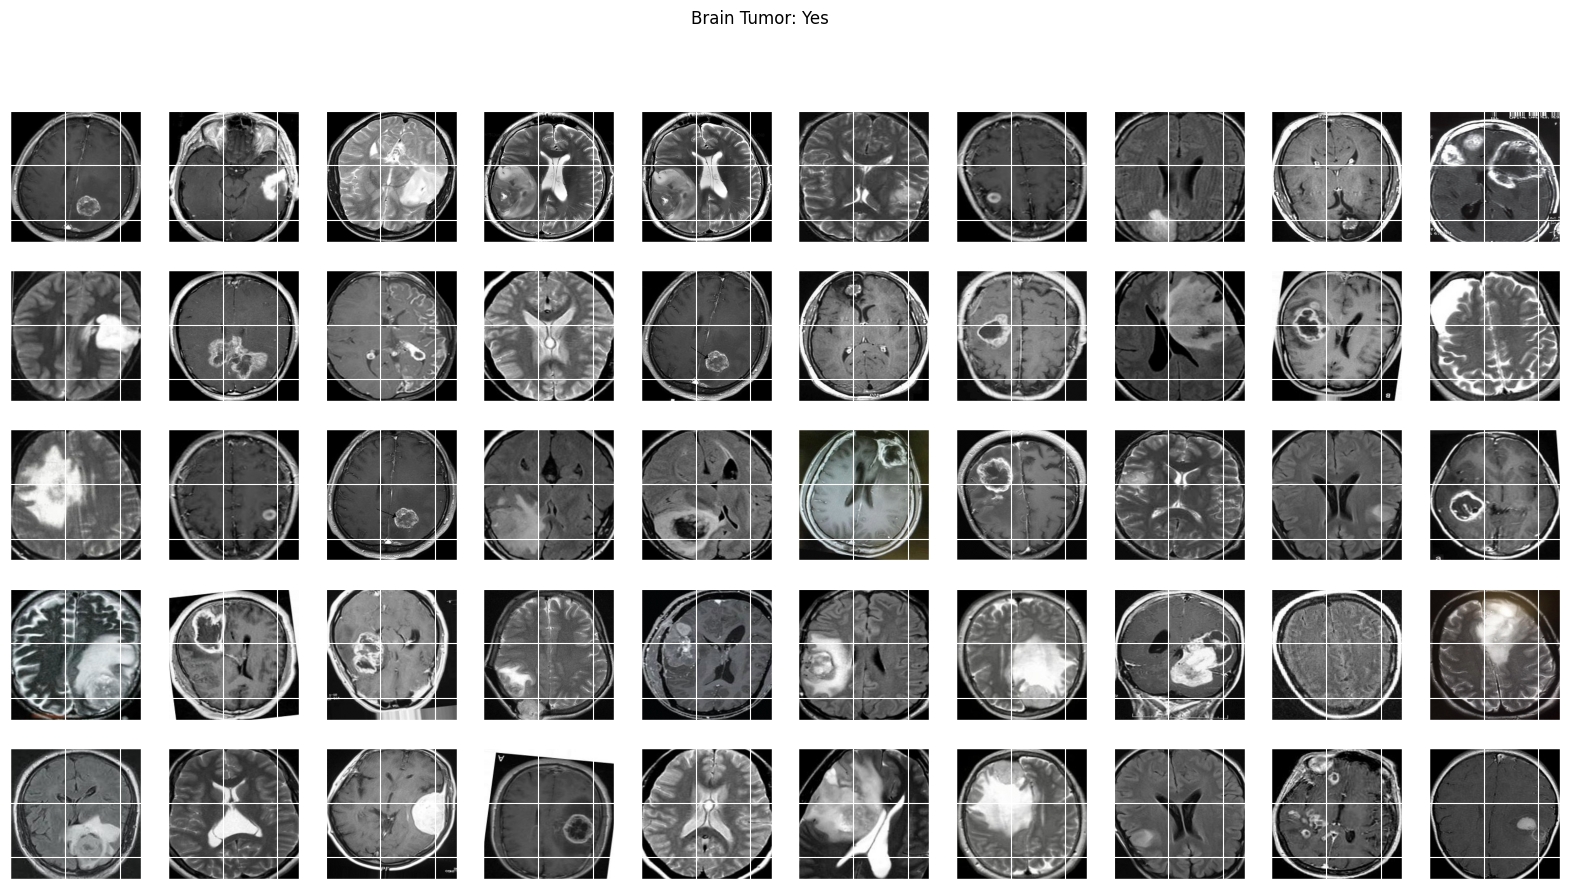

In [ ]:
plot_sample_images(X,y)

# Data Splitting



*   80% - Train
*   10% - Test
*   10% - Validation



Making ```tumorous_and_nontumorous``` directory

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous'):
  os.mkdir('tumorous_and_nontumorous')

Making train, test, valid directory in tumorous_and_nontumorous directory.

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train'):
  os.mkdir('tumorous_and_nontumorous/train')
if not os.path.isdir('tumorous_and_nontumorous/test'):
  os.mkdir('tumorous_and_nontumorous/test')
if not os.path.isdir('tumorous_and_nontumorous/valid'):
  os.mkdir('tumorous_and_nontumorous/valid')

Making tumorous and nontumorous directory in each train, test, valid directory.

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train/tumorous'):
  os.mkdir('tumorous_and_nontumorous/train/tumorous')
if not os.path.isdir('tumorous_and_nontumorous/test/tumorous'):
  os.mkdir('tumorous_and_nontumorous/test/tumorous')
if not os.path.isdir('tumorous_and_nontumorous/valid/tumorous'):
  os.mkdir('tumorous_and_nontumorous/valid/tumorous')

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train/nontumorous'):
  os.mkdir('tumorous_and_nontumorous/train/nontumorous')
if not os.path.isdir('tumorous_and_nontumorous/test/nontumorous'):
  os.mkdir('tumorous_and_nontumorous/test/nontumorous')
if not os.path.isdir('tumorous_and_nontumorous/valid/nontumorous'):
  os.mkdir('tumorous_and_nontumorous/valid/nontumorous')

Moving files from augmented_data folder to tumorous_and_nontumorous folder

```os``` can move files but cannot copy them thats why we need to use ```shutil```

In [ ]:
i = 0
for filename in os.listdir("augmented_data/yes"):
  src = "augmented_data/yes" + "/" + filename
  if i < 759:
    dest = "tumorous_and_nontumorous/train/tumorous" + "/" + filename
  elif i <922:
    dest = "tumorous_and_nontumorous/test/tumorous" + "/" + filename
  else :
    dest = "tumorous_and_nontumorous/valid/tumorous" + "/" + filename
  shutil.copy(src,dest)
  i+=1

In [ ]:
i = 0
for filename in os.listdir("augmented_data/no"):
  src = "augmented_data/no" + "/" + filename
  if i < 686:
    dest = "tumorous_and_nontumorous/train/nontumorous" + "/" + filename
  elif i <833:
    dest = "tumorous_and_nontumorous/test/nontumorous" + "/" + filename
  else :
    dest = "tumorous_and_nontumorous/valid/nontumorous" + "/" + filename
  shutil.copy(src,dest)
  i+=1

# Model Building

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
print(len(os.listdir("tumorous_and_nontumorous/train/tumorous")))
print(len(os.listdir("tumorous_and_nontumorous/train/nontumorous")))
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')
print(len(os.listdir("tumorous_and_nontumorous/train/tumorous")))
print(len(os.listdir("tumorous_and_nontumorous/train/nontumorous")))

759
686
Found 1445 images belonging to 2 classes.
759
686


In [ ]:
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 310 images belonging to 2 classes.


In [ ]:
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 235 images belonging to 2 classes.


In [ ]:
class_labels = train_generator.class_indices
print(class_labels)
class_name = {value: key for (key,value) in class_labels.items()} # reversing dictionary
print(class_name)

{'nontumorous': 0, 'tumorous': 1}
{0: 'nontumorous', 1: 'tumorous'}


In [ ]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

# model is aready trained thats why marking false
for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x) # Flatten() is the bridge between convolutional layers and dense layers.

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output) # used to build end to end model
model_01.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

Purpose: Stops training early when validation loss stops improving.

- monitor='val_loss': Watches the validation loss.

- mode='min': Training stops when loss doesn't decrease.

- patience=4: Waits 4 epochs before stopping after no improvement.

- verbose=1: Prints messages.

In [ ]:
# callback
filepath = 'model.h5'
# early stop training
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=4)
# save model during training
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
# reduce learning rate
lrr = ReduceLROnPlateau(monitor='val_accuaracy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [ ]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_01.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs = 2, callbacks=[es,cp,lrr], validation_data=valid_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.5472 - loss: 0.8009 
Epoch 1: val_loss improved from inf to 0.68318, saving model to model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 471s 49s/step - accuracy: 0.5426 - loss: 0.7996 - val_accuracy: 0.5489 - val_loss: 0.6832 - learning_rate: 1.0000e-04
Epoch 2/2


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_accuaracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.5128 - loss: 0.7343 
Epoch 2: val_loss did not improve from 0.68318
10/10 ━━━━━━━━━━━━━━━━━━━━ 466s 49s/step - accuracy: 0.5128 - loss: 0.7340 - val_accuracy: 0.5149 - val_loss: 0.7137 - learning_rate: 1.0000e-04


In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath="model_weights/vgg19_model_01.weights.h5", overwrite=True)

In [ ]:
model_01.load_weights("model_weights/vgg19_model_01.weights.h5")
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 192s 24s/step - accuracy: 0.4848 - loss: 0.7268
10/10 ━━━━━━━━━━━━━━━━━━━━ 244s 24s/step - accuracy: 0.5359 - loss: 0.7062


In [ ]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Acc: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print(f'Testing Acc: {vgg_test_eval_01[1]}')

Validation Loss: 0.7263866066932678
Validation Acc: 0.47659575939178467
Testing Loss: 0.7197406888008118
Testing Acc: 0.5322580933570862


In [ ]:
filenames = test_generator.filenames
nb_sample = len(filenames)

vgg_prediction_01 = model_01.predict(test_generator, steps=nb_sample, verbose = 1)
y_pred = np.argmax(vgg_prediction_01, axis=1)

310/310 ━━━━━━━━━━━━━━━━━━━━ 258s 748ms/step 


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


## Freezing above block5_conv4, block5_conv3 only

In [ ]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.weights.h5')

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 125,641,602 (479.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [ ]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_02.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [ ]:
history_02 = model_02.fit(train_generator, steps_per_epoch=10, epochs = 2, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_27']
Received: inputs=Tensor(shape=(None, 240, 240, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.5365 - loss: 0.7106 
Epoch 1: val_loss improved from 0.68318 to 0.66724, saving model to model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 519s 54s/step - accuracy: 0.5357 - loss: 0.7110 - val_accuracy: 0.5915 - val_loss: 0.6672 - learning_rate: 1.0000e-04
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29s/step - accuracy: 0.5236 - loss: 0.7221 
Epoch 2: val_loss improved from 0.66724 to 0.66252, saving model to model.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 522s 55s/step - accuracy: 0.5265 - loss: 0.7199 - val_accuracy: 0.5532 - val_loss: 0.6625 - learning_rate: 1.0000e-04


In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath="model_weights/vgg19_model_02.weights.h5", overwrite=True)

In [ ]:
model_02.load_weights("model_weights/vgg19_model_02.weights.h5")
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 183s 22s/step - accuracy: 0.6050 - loss: 0.6597
10/10 ━━━━━━━━━━━━━━━━━━━━ 248s 25s/step - accuracy: 0.5757 - loss: 0.6744


In [60]:
!cp -r model_weights/ drive/MyDrive/model_weights

# Training full model

In [62]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights('model_weights/vgg19_model_02.weights.h5')

sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_03.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])
model_03.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 140,946,370 (537.67 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
history_03 = model_03.fit(train_generator, steps_per_epoch=10, epochs = 2, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_108']
Received: inputs=Tensor(shape=(None, 240, 240, 3))
  warnings.warn(msg)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 80s/step - accuracy: 0.5827 - loss: 0.6935  
Epoch 1: val_loss did not improve from 0.66252
10/10 ━━━━━━━━━━━━━━━━━━━━ 998s 100s/step - accuracy: 0.5806 - loss: 0.6952 - val_accuracy: 0.6213 - val_loss: 0.6641 - learning_rate: 1.0000e-04
Epoch 2/2


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_accuaracy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 88s/step - accuracy: 0.5913 - loss: 0.6968  
Epoch 2: val_loss did not improve from 0.66252
10/10 ━━━━━━━━━━━━━━━━━━━━ 1060s 108s/step - accuracy: 0.5904 - loss: 0.6964 - val_accuracy: 0.5234 - val_loss: 0.7153 - learning_rate: 1.0000e-04


In [65]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save_weights(filepath="model_weights/vgg19_model_03.weights.h5", overwrite=True)

In [66]:
!cp -r model_weights/ drive/MyDrive/model_weights

In [ ]:
model_03.load_weights("model_weights/vgg19_model_03.h5")
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

In [ ]:
!cp /content/tumorous_and_nontumorous /drive/MyDrive/Brain_Tumor_Detection/tumorous_and_nontumorous
!cp /content/augmented_data /drive/MyDrive/Brain_Tumor_Detection/augmented_data
!cp /content/model_weights /driveMyDrive/Brain_Tumor_Detection/model_weights